# Filtering tiles
We can reduce the compute time and prevent many false-positive errors by restricting the analysis to the tiles that are likely to contain sea ice. 

1. Analysis of the validation dataset
2. Examples with large images.

In [6]:
using Pkg
Pkg.activate("calval")
using IceFloeTracker
using Images
using CSV
# include("../scripts/dev/validation_data.jl")

  Activating project at `~/Documents/research/calval_tgrs/notebooks/calval`
[ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b] (cache misses: wrong dep version loaded (4), incompatible header (12), mismatched flags (2))


In [7]:
using Plots

In [13]:
cloud_mask_settings = (
    prelim_threshold=53.0/255.,
    band_7_threshold=130.0/255.,
    band_2_threshold=169.0/255.,
    ratio_lower=0.0,
    ratio_offset=0.0,
    ratio_upper=0.53
)

cmask = LopezAcostaCloudMask(cloud_mask_settings...)
dataloc = "../data/validation_dataset/modis_500km"
tc_filenames = filter(x -> !occursin(".DS", x), readdir(joinpath(dataloc, "truecolor")))


data_loader = Watkins2025GitHub(; ref="a451cd5e62a10309a9640fbbe6b32a236fcebc70")
dataset = data_loader(c -> c.case_number == 31 && c.satellite == "aqua");

┌ Warning: In /tmp/Watkins2025/a451cd5e62a10309a9640fbbe6b32a236fcebc70/validation_dataset.csv line 381 has 0 fields but 28 fields are expected. Skipping row.
└ @ TextParse ~/.julia/packages/TextParse/bX5Ws/src/csv.jl:390


In [15]:
case = first(dataset)
landmask = Gray.(case.modis_landmask) .> 0
tc_img .* .! landmask

LoadError: UndefVarError: `tc_img` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [16]:
"""Compute the fraction of non-ocean pixels covered by cloud"""
function ocean_cloud_fraction(cloudmask, landmask)
    lm = vec(landmask)
    cf = vec(cloudmask)[.!lm]
    length(cf) > 0 ? (return round(mean(cf), digits=3)) : (return NaN)
end

"""Compute the contrast by differencing the 99th and 1st percentile"""
function robust_contrast(img_band, landmask; min_pct=1, max_pct=99)
    lm = vec(landmask)
    band_data = vec(img_band)[.!lm]
    length(band_data) > 0 ? (return round(percentile(band_data, max_pct) - percentile(band_data, min_pct), digits=3)) : (return 0)
end

"""Compute the fraction of non-cloudy ocean pixels with band 2 brightness above a given threshold"""
function possible_clear_sky_sea_ice(band_2, cloudmask, landmask; possible_ice_threshold=75/255)
    ocean_nocloud = vec(.! (landmask .| cloudmask))
    b2 = vec(band_2)[ocean_nocloud]
    length(b2) > 0 ? (return round(mean(b2 .> possible_ice_threshold), digits=3)) : (return 0)
end

possible_clear_sky_sea_ice

In [17]:
using Statistics 
using StatsBase

function get_image_stats(tc_image, fc_image, cloud_mask, land_mask, tile_markers, tiles)
    df = DataFrame(
                   tile_index=Int16[],
                   ground_truth=[],
                   cloud_fraction=Float64[],                   
                   land_fraction=Float64[],
                   truecolor_band_1_contrast=Float64[],
                   falsecolor_band_2_contrast=Float64[],
                   falsecolor_band_7_contrast=Float64[],
                   truecolor_band_1_entropy=Float64[],
                   falsecolor_band_2_entropy=Float64[],
                   falsecolor_band_7_entropy=Float64[],
                   possible_sea_ice_fraction=Float64[]
                   )
    
    for (index, tile) in enumerate(tiles)
        push!(df, (
                   tile_index = index,
                   ground_truth = maximum(tile_markers[tile...]) > 0,
                   cloud_fraction = ocean_cloud_fraction(cloud_mask[tile...], land_mask[tile...]),
                   land_fraction = mean(land_mask[tile...]),
                   truecolor_band_1_contrast = robust_contrast(red.(tc_image[tile...]), land_mask[tile...]),
                   falsecolor_band_2_contrast = robust_contrast(green.(fc_image[tile...]), land_mask[tile...]),
                   falsecolor_band_7_contrast = robust_contrast(red.(fc_image[tile...]), land_mask[tile...]),
                   truecolor_band_1_entropy = Images.entropy(red.(tc_image[tile...]) .* .! land_mask[tile...]), 
                   falsecolor_band_2_entropy = Images.entropy(green.(fc_image[tile...]) .* .! land_mask[tile...]),
                   falsecolor_band_7_entropy = Images.entropy(red.(fc_image[tile...]) .* .! land_mask[tile...]),
                   possible_sea_ice_fraction = possible_clear_sky_sea_ice(
                                                    green.(fc_image[tile...]),
                                                    cloud_mask[tile...],
                                                    land_mask[tile...]))
                )
    end
    return df
end

get_image_stats (generic function with 1 method)

In [206]:

for tc_filename in tc_filenames

    fc_filename = replace(tc_filename, "truecolor" => "falsecolor")
    markers_filename = replace(replace(tc_filename, "truecolor" => "markers"), "tiff" => "png")
    landmask_filename = occursin("aqua", tc_filename) ? replace(tc_filename, "aqua-" => "") : replace(tc_filename, "terra-" => "")
    landmask_filename = replace(landmask_filename, "truecolor" => "landmask")



    landmask_filename = occursin("aqua", tc_filename) ? replace(tc_filename, "aqua-" => "") : replace(tc_filename, "terra-" => "")
    landmask_filename = replace(landmask_filename, "truecolor" => "landmask")
    
    tc_image = RGB.(load(joinpath(dataloc, "truecolor", tc_filename)))
    fc_image = RGB.(load(joinpath(dataloc, "falsecolor", replace(tc_filename, "truecolor" => "falsecolor"))))
    tile_markers = Gray.(load(joinpath(dataloc, "tile_markers", markers_filename))) .> 0
    land_image = Gray.(load(joinpath(dataloc, "landmask", landmask_filename)))
    
    cloud_mask = IceFloeTracker.create_cloudmask(fc_image, cmask)
    land_mask = land_image .> 0.1
    
    # with 256 m pixels instead of our usual 250 m tiles, we have approx 98 pixels per 25 km.
    tiles = IceFloeTracker.get_tiles(tc_image, 2*98)
    
    # use the markers to make a checkerboard
    for tile in filter(t -> maximum(tile_markers[t...]) .> 0, tiles)
        tile_markers[tile...] .= 1
    end

    df = get_image_stats(tc_image, fc_image, cloud_mask, land_mask, tile_markers, tiles)
    
    CSV.write(joinpath(dataloc, "50km_data_tables/", replace(tc_filename, "truecolor.tiff" => "statistics.csv")), df)
end

In [13]:
tc_filenames

18-element Vector{String}:
 "001-baffin_bay-500km-20220911-aqua-250m-truecolor.tiff"
 "001-baffin_bay-500km-20220911-terra-250m-truecolor.tiff"
 "022-barents_kara_seas-500km-20060909-aqua-250m-truecolor.tiff"
 "022-barents_kara_seas-500km-20060909-terra-250m-truecolor.tiff"
 "043-beaufort_sea-500km-20190813-aqua-250m-truecolor.tiff"
 "043-beaufort_sea-500km-20190813-terra-250m-truecolor.tiff"
 "065-bering_chukchi_seas-500km-20080507-aqua-250m-truecolor.tiff"
 "065-bering_chukchi_seas-500km-20080507-terra-250m-truecolor.tiff"
 "086-east_siberian_sea-500km-20060927-aqua-250m-truecolor.tiff"
 "086-east_siberian_sea-500km-20060927-terra-250m-truecolor.tiff"
 "106-greenland_sea-500km-20140911-aqua-250m-truecolor.tiff"
 "106-greenland_sea-500km-20140911-terra-250m-truecolor.tiff"
 "128-hudson_bay-500km-20190415-aqua-250m-truecolor.tiff"
 "128-hudson_bay-500km-20190415-terra-250m-truecolor.tiff"
 "148-laptev_sea-500km-20110324-aqua-250m-truecolor.tiff"
 "148-laptev_sea-500km-20110324-terra-25

In [211]:
tc_filename = "086-east_siberian_sea-500km-20060927-aqua-250m-truecolor.tiff"
fc_filename = replace(tc_filename, "truecolor" => "falsecolor")
markers_filename = replace(replace(tc_filename, "truecolor" => "markers"), "tiff" => "png")
landmask_filename = occursin("aqua", tc_filename) ? replace(tc_filename, "aqua-" => "") : replace(tc_filename, "terra-" => "")
landmask_filename = replace(landmask_filename, "truecolor" => "landmask")

landmask_filename = occursin("aqua", tc_filename) ? replace(tc_filename, "aqua-" => "") : replace(tc_filename, "terra-" => "")
landmask_filename = replace(landmask_filename, "truecolor" => "landmask")

tc_image = RGB.(load(joinpath(dataloc, "truecolor", tc_filename)))
fc_image = RGB.(load(joinpath(dataloc, "falsecolor", replace(tc_filename, "truecolor" => "falsecolor"))))
true_markers = Gray.(load(joinpath(dataloc, "tile_markers", markers_filename))) .> 0
land_image = Gray.(load(joinpath(dataloc, "landmask", landmask_filename)));
cloud_mask = IceFloeTracker.create_cloudmask(fc_image, cmask)
land_mask = land_image .> 0.1; # Replace with landmask, use dilated land mask in computation

In [212]:
# Fitted lognormal function from the Python analysis
# The function produces a probability where prob=0 should be masked.
# This function was fitted to 25 km squares. Seems like it performs well with 50 km, also -- would need to check though.

function fitted_log_function(truecolor_band_1_contrast,
                             falsecolor_band_7_contrast,
                             cloud_fraction,
                             possible_sea_ice_fraction;
    # parameters = [-1.32476523, 7.235885, -3.741664, -3.116937, 2.985701]) # Slight differences between samples
    parameters = [-1.25044852, 6.817628, -3.874728, -2.923836, 2.974168])
    X = [1, truecolor_band_1_contrast, falsecolor_band_7_contrast, cloud_fraction, possible_sea_ice_fraction]
    
    return 1 / (1 + exp(-sum(X .* parameters)))
end

function filter_function(true_color, false_color, cloud_mask, land_mask; land_thresh=0.9, prob_thresh=0.5)
    land_frac = mean(land_mask)
    land_frac > land_thresh && (return false)
    
    b1_contrast = robust_contrast(red.(true_color), land_mask)
    b7_contrast = robust_contrast(red.(false_color), land_mask)
    cloudfrac = ocean_cloud_fraction(cloud_mask, land_mask)
    poss_ice = possible_clear_sky_sea_ice(green.(false_color), cloud_mask, land_mask)

    p = fitted_log_function(b1_contrast, b7_contrast, cloudfrac, poss_ice)
    return p > prob_thresh
end

filter_function (generic function with 1 method)

In [213]:
tiles = IceFloeTracker.get_tiles(tc_image, 98)

# use the markers to make a checkerboard
for tile in filter(t -> maximum(true_markers[t...]) .> 0, tiles)
    true_markers[tile...] .= 1
end

In [214]:
tile_markers = zeros(size(cloud_mask))
for tile in filter(t -> filter_function(tc_image[t...], fc_image[t...], cloud_mask[t...], land_mask[t...]), tiles)
    tile_markers[tile...] .= 1
end

tc_masked = IceFloeTracker.apply_landmask(tc_image, .!land_mask)
tc_masked = tc_masked .* tile_markers;

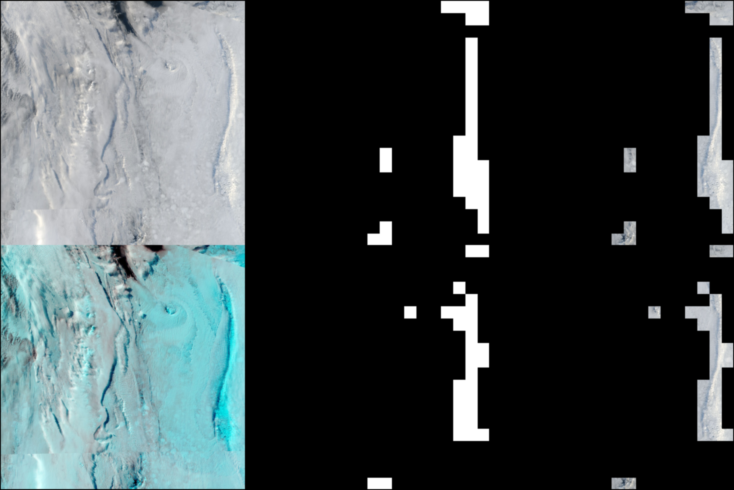

In [215]:
mosaicview(tc_image, fc_image, Gray.(true_markers), Gray.(tile_markers), tc_image .* true_markers, tc_image .* tile_markers, nrow=2)

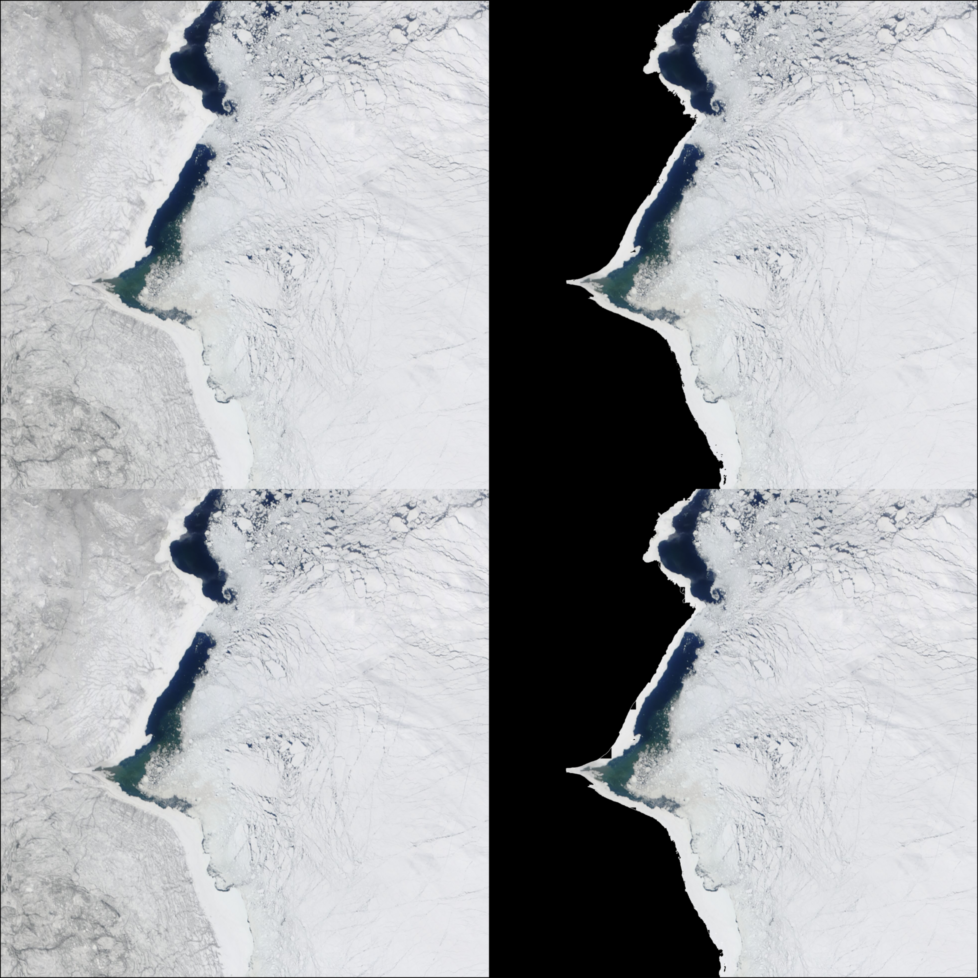

In [130]:
coast = Gray.(land_mask .- erode(land_mask))
mosaicview(tc_image, tc_image .* (1 .- cloud_mask), tc_image .* (1 .- land_mask), tc_masked .+ coast, nrow=2)

In [170]:
tc_img = load("../../IceFloeTracker.jl/test/test_inputs/beaufort-chukchi-seas_truecolor.2020162.aqua.250m.tiff")
fc_img = load("../../IceFloeTracker.jl/test/test_inputs/beaufort-chukchi-seas_falsecolor.2020162.aqua.250m.tiff")
cloud_mask = IceFloeTracker.create_cloudmask(fc_img, cmask)
land_mask = IceFloeTracker.create_landmask(load("../../IceFloeTracker.jl/test/test_inputs/landmask.tiff"), strel_diamond((11,11)))

(dilated = Bool[1 1 … 1 1; 1 1 … 1 1; … ; 0 0 … 1 1; 0 0 … 1 1], non_dilated = Bool[1 1 … 1 1; 1 1 … 1 1; … ; 0 0 … 1 1; 0 0 … 1 1])

In [204]:
tiles = IceFloeTracker.get_tiles(tc_img, 200)
tile_markers = zeros(size(cloud_mask))
for tile in filter(t -> filter_function(tc_img[t...], fc_img[t...], cloud_mask[t...], .!land_mask.dilated[t...]), tiles)
    tile_markers[tile...] .= 1
end

tc_masked = tc_img .* land_mask.non_dilated
tc_masked = tc_masked .* tile_markers;

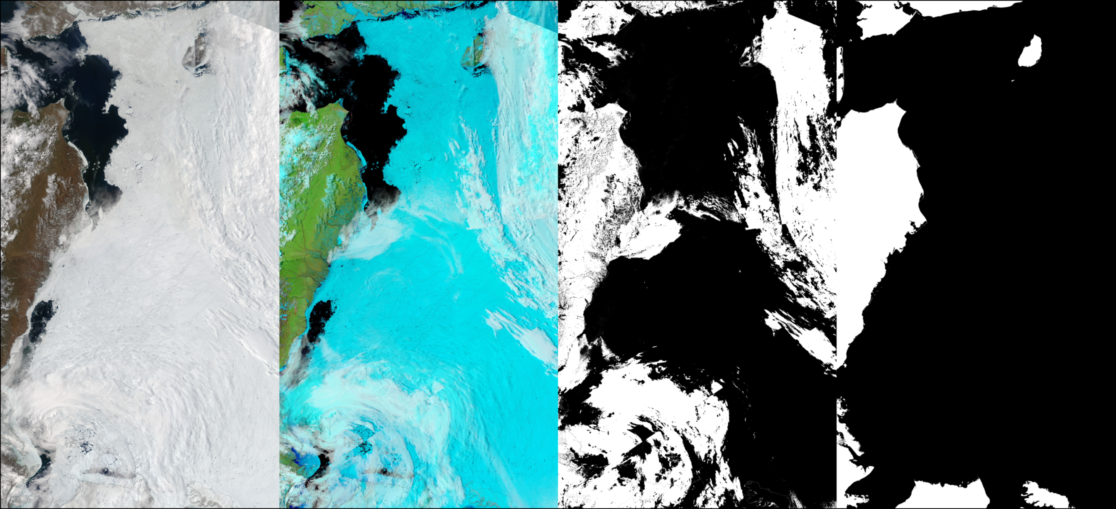

In [201]:
mosaicview(tc_img, fc_img, Gray.(cloud_mask), Gray.(.!land_mask.non_dilated), nrow=1)

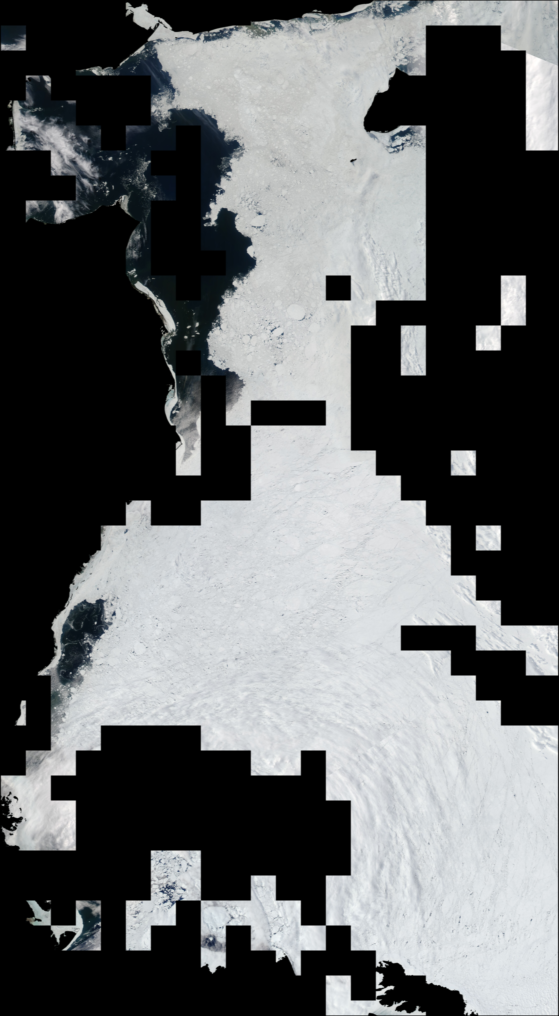

In [205]:
tc_masked

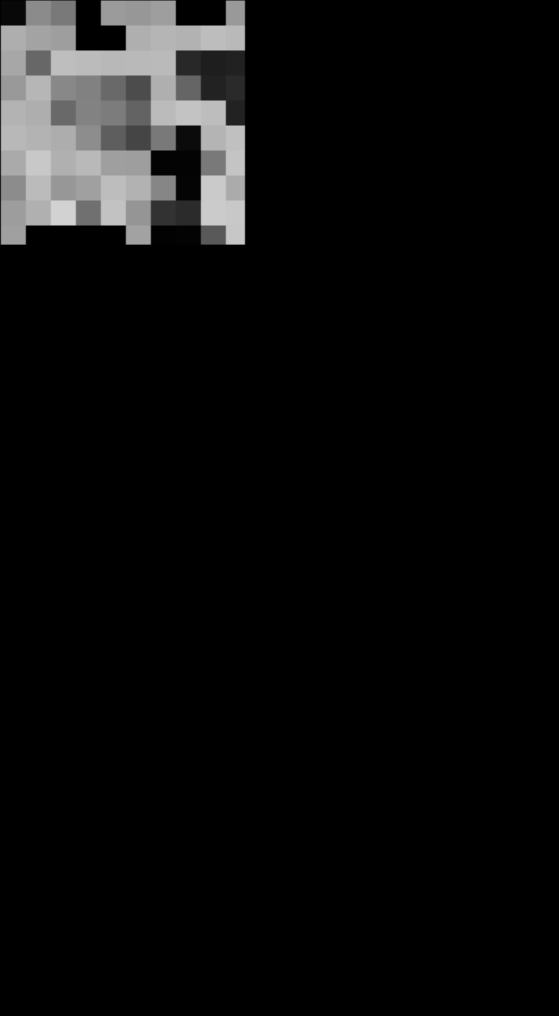

In [203]:
# Result looks super different - look into this case. Why is the cloud mask odd?
Gray.(red_contrast)

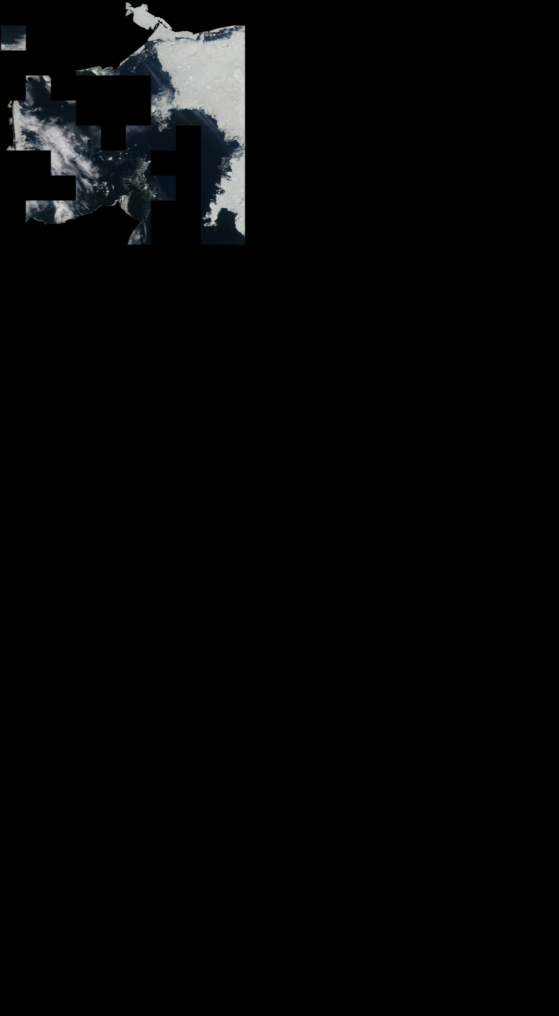

In [200]:
tc_masked

In [149]:
# grid for the large images
# Image is 1953 by 1953 pixels (pixel is 256 m)
# Other images from project are 250 m / pixel.

size(tc_img) ./ 100

(81.2, 44.58)

In [78]:
fitted_log_function(truecolor_band_1_contrast,
                             falsecolor_band_7_contrast,
                             cloud_fraction,
                             possible_sea_ice_fraction;
    parameters = [-1.32476523, 7.235885, -3.741664, -3.116937, 2.985701])
    X = [1, truecolor_band_1_contrast, falsecolor_band_7_contrast, cloud_fraction, possible_sea_ice_fraction]
    
    return 1 / (1 + exp(-sum(X .* parameters)))
end

function prob_function(true_color, false_color, cloud_mask, land_mask; land_thresh=0.9, prob_thresh=0.5)
    land_frac = mean(land_mask)
    land_frac > land_thresh && (return false)
    
    b1_contrast = robust_contrast(red.(true_color), land_mask)
    b7_contrast = robust_contrast(red.(false_color), land_mask)
    cloudfrac = ocean_cloud_fraction(cloud_mask, land_mask)
    poss_ice = possible_clear_sky_sea_ice(green.(false_color), cloud_mask, land_mask)

    p = fitted_log_function(b1_contrast, b7_contrast, cloudfrac, poss_ice)

In [68]:
robust_contrast(red.(tc_img)

19.928571428571427